In [59]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import openml
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegressionCV

In [60]:
task = openml.tasks.get_task(43)
# task = openml.tasks.get_task(361071)
dataset = task.get_dataset()
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)
# downsample to 2000 samples for X, y
X = X[:2000]
y = y[:2000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
print("Covariate Shapes: ", X_train.shape, X_valid.shape, X_test.shape)

Covariate Shapes:  (1200, 57) (400, 57) (400, 57)


/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/pytho

In [61]:
class TreeRouterMoE:
    def __init__(self, n_trees_to_use=3):
        """
        Initialize the Mixed Experts model with MLP router for Random Forest
        
        Parameters:
        -----------
        n_trees_to_use : int
            Number of trees to route each sample to
        """
        self.n_trees_to_use = n_trees_to_use
        self.rf_model = None
        self.router_model = None
        self.tree_importances = None
        
    def fit(self, X_train, y_train, X_valid, y_valid, 
           rf_params=None, mlp_params=None):
        """
        Fit the Random Forest and train the MLP router
        
        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training labels
        X_valid : array-like
            Validation features
        y_valid : array-like
            Validation labels
        rf_params : dict
            Parameters for RandomForestClassifier
        mlp_params : dict
            Parameters for MLPClassifier
        """
        # Default parameters if none provided
        if rf_params is None:
            rf_params = {
                'n_estimators': 100,
                'random_state': 42
            }
        
        if mlp_params is None:
            mlp_params = {
                'hidden_layer_sizes': (64, 32),
                'activation': 'relu',
                'solver': 'adam',
                'max_iter': 1000,
                'random_state': 42
            }
                
        # Step 1: Train Random Forest
        self.rf_model = RandomForestClassifier(**rf_params)
        self.rf_model.fit(X_train, y_train)
        # Step 2: Calculate the performance of each tree on validation set
        n_trees = len(self.rf_model.estimators_)
        tree_performance = []

        for i in tqdm(range(n_trees)):
            tree = self.rf_model.estimators_[i]
            # Get predictions from this tree
            if hasattr(tree, "predict_proba"):
                y_pred_proba = tree.predict_proba(X_valid)[:, 1]
                tree_auc = roc_auc_score(y_valid, y_pred_proba)
            else:
                y_pred = tree.predict(X_valid)
                tree_auc = accuracy_score(y_valid, y_pred)
            tree_performance.append(tree_auc)

        self.tree_importances = np.array(tree_performance)

        # Step 3: Create training data for the router
        router_X = []
        router_y = []

        # For each validation sample, determine which trees perform best
        for i in range(len(X_valid)):
            sample = X_valid[i:i+1]
            true_label = int(y_valid[i])

            # Get prediction correctness for each tree
            tree_correctness = []
            for j in range(n_trees):
                tree = self.rf_model.estimators_[j]
                pred = int(tree.predict(sample)[0])
                # print("pred type: ", type(pred), "true_label type: ", type(true_label))
                # print("pred: ", pred, "true_label: ", true_label, "pred == true_label: ", pred == true_label)
                correctness = 1 if pred == true_label else 0
                tree_correctness.append(correctness)

            # Add to router training data
            router_X.append(X_valid[i])
            router_y.append(tree_correctness)
        print(router_y)
        router_X = np.array(router_X)
        router_y = np.array(router_y)

        # Step 4: Train the MLP router
        self.router_model = MLPRegressor(**mlp_params)
        
        # Reshape router_y to be a single column with n_trees rows
        # Convert to probabilistic targets - we want the router to learn
        # which trees are more likely to be correct
        router_y_normalized = router_y / np.sum(router_y, axis=1, keepdims=True)
        
        # Handle any NaN values from division by zero        
        router_y_normalized = np.nan_to_num(router_y_normalized, 1.0/n_trees)
        print(router_y_normalized.shape)
        # print unique values in router_y_normalized
        print(np.unique(router_y_normalized))
        print("router_y_normalized")
        print(router_y_normalized)
        # Fit the router model
        self.router_model.fit(router_X, router_y_normalized)
        # report the loss of the router model
        print("Router Model Loss: ", self.router_model.loss_)
        # Evaluate full model on validation set
        y_valid = y_valid.astype(int)
        val_acc = self.evaluate(X_valid, y_valid)
        print(f"Validation accuracy: {val_acc:.4f}")
        
        return self
    
    def route_sample(self, X_sample):
        """
        Route a single sample to the best trees
        
        Parameters:
        -----------
        X_sample : array-like
            Single sample features
            
        Returns:
        --------
        list
            Indices of the best trees for this sample
        """
        if self.router_model is None:
            raise ValueError("Router model not trained yet. Call fit() first.")
        
        # Get router predictions
        # tree_probs = self.router_model.predict_proba([X_sample])[0]
        tree_probs = self.router_model.predict([X_sample])[0]
        
        # Select the top n_trees_to_use trees
        best_tree_indices = np.argsort(tree_probs)[-self.n_trees_to_use:]
        
        return best_tree_indices
    
    def predict(self, X):
        """
        Make predictions using the MoE model
        
        Parameters:
        -----------
        X : array-like
            Test features
            
        Returns:
        --------
        array
            Predicted labels
        """
        if self.rf_model is None or self.router_model is None:
            raise ValueError("Models not trained yet. Call fit() first.")
        
        predictions = []
        
        for i in range(len(X)):
            # Get best trees for this sample
            best_trees = self.route_sample(X[i])
            
            # Collect votes from the best trees
            votes = []
            for tree_idx in best_trees:
                tree = self.rf_model.estimators_[tree_idx]
                votes.append(tree.predict([X[i]])[0])
            
            # Majority vote
            final_pred = max(set(votes), key=votes.count)
            predictions.append(final_pred)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Make probability predictions using the MoE model
        
        Parameters:
        -----------
        X : array-like
            Test features
            
        Returns:
        --------
        array
            Predicted probabilities
        """
        if self.rf_model is None or self.router_model is None:
            raise ValueError("Models not trained yet. Call fit() first.")
        
        probabilities = []
        
        for i in range(len(X)):
            # Get best trees for this sample
            best_trees = self.route_sample(X[i])
            
            # Collect probabilities from the best trees
            probs = []
            for tree_idx in best_trees:
                tree = self.rf_model.estimators_[tree_idx]
                if hasattr(tree, "predict_proba"):
                    probs.append(tree.predict_proba([X[i]])[0][1])
                else:
                    # If the tree doesn't support predict_proba, use binary prediction
                    probs.append(float(tree.predict([X[i]])[0]))
            
            # Average probability
            final_prob = np.mean(probs)
            probabilities.append(final_prob)
        
        # Return probabilities in the format [[1-p, p], [1-p, p], ...]
        return np.column_stack((1 - np.array(probabilities), np.array(probabilities)))
    
    def evaluate(self, X, y):
        """
        Evaluate the model performance
        
        Parameters:
        -----------
        X : array-like
            Features
        y : array-like
            True labels
            
        Returns:
        --------
        float
            Accuracy score
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def analyze_routing(self, X, n_samples=100):
        """
        Analyze how samples are routed to different trees
        
        Parameters:
        -----------
        X : array-like
            Features
        n_samples : int
            Number of samples to analyze
            
        Returns:
        --------
        dict
            Routing statistics
        """
        if self.router_model is None:
            raise ValueError("Router model not trained yet. Call fit() first.")
        
        # Select a subset of samples
        indices = np.random.choice(len(X), min(n_samples, len(X)), replace=False)
        X_subset = X[indices]
        
        # Analyze routing
        tree_usage = np.zeros(len(self.rf_model.estimators_))
        
        for i in range(len(X_subset)):
            best_trees = self.route_sample(X_subset[i])
            for tree_idx in best_trees:
                tree_usage[tree_idx] += 1
        
        # Normalize
        tree_usage = tree_usage / len(X_subset)
        
        # Plot tree usage
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(tree_usage)), tree_usage)
        plt.xlabel('Tree Index')
        plt.ylabel('Usage Frequency')
        plt.title('Tree Usage by the Router')
        plt.tight_layout()
        
        return {
            "tree_usage": tree_usage,
            "most_used_trees": np.argsort(tree_usage)[-10:],
            "least_used_trees": np.argsort(tree_usage)[:10]
        }

def test_performance():
    
    # Split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.4, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print("Covariate Shapes: ", X_train.shape, X_valid.shape, X_test.shape)
    # Initialize and train the MoE model
    moe = TreeRouterMoE(n_trees_to_use=10)
    moe.fit(X_train, y_train, X_valid, y_valid, 
           rf_params={'n_estimators': 100, 'random_state': 42},
           mlp_params={'hidden_layer_sizes': (64, 32), 'random_state': 42})

    # Evaluate on test set
    y_test_int = y_test.astype(int)
    test_acc = moe.evaluate(X_test, y_test_int)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Compare with standard Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_test_acc = accuracy_score(y_test, rf.predict(X_test))
    print(f"Standard Random Forest test accuracy: {rf_test_acc:.4f}")
    
    # Analyze routing
    routing_stats = moe.analyze_routing(X_test)
    
    return moe, routing_stats


Covariate Shapes:  (1200, 57) (400, 57) (400, 57)


100%|██████████| 100/100 [00:00<00:00, 323.45it/s]


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_181571/3620577460.py:104: RuntimeWarning: invalid value encountered in divide
  router_y_normalized = router_y / np.sum(router_y, axis=1, keepdims=True)


Router Model Loss:  0.0060687518540837836
Validation accuracy: 0.9450
Test accuracy: 0.9700
Standard Random Forest test accuracy: 0.9775


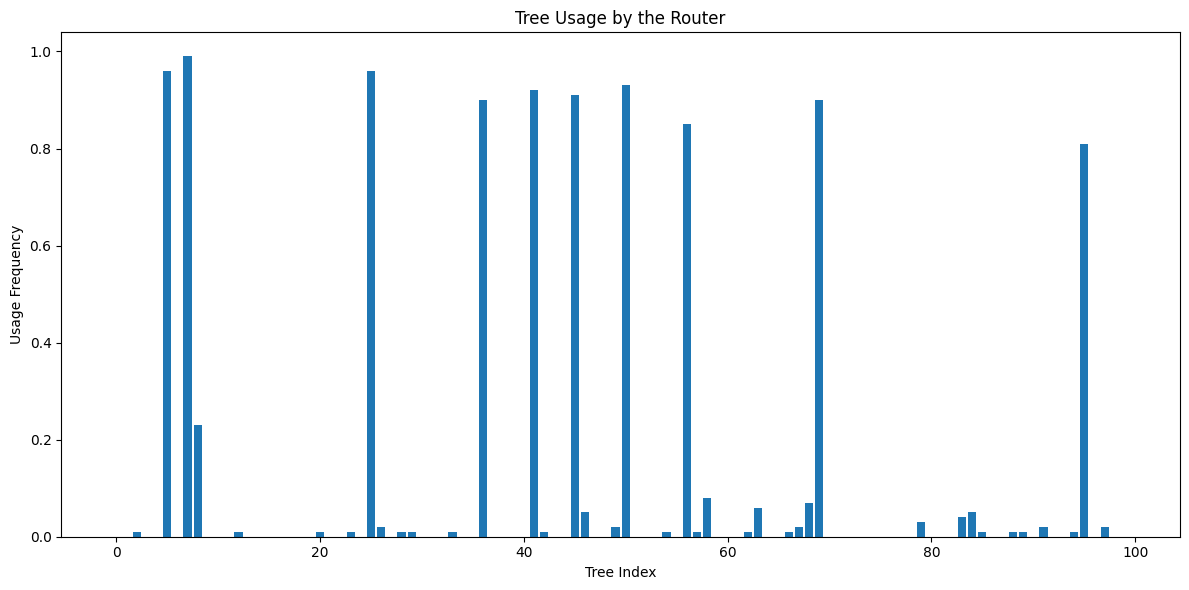

In [62]:
moe, routing_stats = test_performance()